# Analise da base do DataSUS sobre casos de dengue no primeiro semestre de 2025
Buscamos a base com dados de dengue do portal [https://opendatasus.saude.gov.br/gl/dataset/arboviroses-dengue](https://opendatasus.saude.gov.br/gl/dataset/arboviroses-dengue/resource/5c9132a9-77c2-4b15-8afc-a43c58fc9ec0?inner_span=True)

O Dataset contém dados de casos de dengue coletados na primeira metade de 2025.

Com base nessas informações queremos responder as seguintes perguntas:

1. Se existe relação entre o municipio em que uma pessoa mora com a probabilidade de contrair dengue?
2. Quais sintomas estão mais relacionados a dengue? 

Ao final, avaliaremos qual modelo é melhor para ajudar médicos na detecção de possíveis casos de Dengue e seu tipo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

pd.set_option('display.max_columns', None)  # Mostra todas as colunas
pd.set_option('display.expand_frame_repr', False) 

df = pd.read_csv("dados_dengue.csv")
df.head()

C:\Users\caioo\AppData\Local\Temp\ipykernel_7460\497345660.py:4: DtypeWarning: Columns (22,44,45,46,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dados_dengue.csv")


,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,SEM_PRI,ANO_NASC,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_PAIS,DT_INVEST,ID_OCUPA_N,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,DT_CHIK_S1,DT_CHIK_S2,DT_PRNT,RES_CHIKS1,RES_CHIKS2,RESUL_PRNT,DT_SORO,RESUL_SORO,DT_NS1,RESUL_NS1,DT_VIRAL,RESUL_VI_N,DT_PCR,RESUL_PCR_,SOROTIPO,HISTOPA_N,IMUNOH_N,HOSPITALIZ,DT_INTERNA,UF,MUNICIPIO,TPAUTOCTO,COUFINF,COPAISINF,COMUNINF,CLASSI_FIN,CRITERIO,DOENCA_TRA,CLINC_CHIK,EVOLUCAO,DT_OBITO,DT_ENCERRA,ALRM_HIPOT,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,DT_ALRM,GRAV_PULSO,GRAV_CONV,GRAV_ENCH,GRAV_INSUF,GRAV_TAQUI,GRAV_EXTRE,GRAV_HIPOT,GRAV_HEMAT,GRAV_MELEN,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,DT_GRAV,MANI_HEMOR,EPISTAXE,GENGIVO,METRO,PETEQUIAS,HEMATURA,SANGRAM,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,CS_FLXRET,FLXRECEBI,MIGRADO_W
0,2,A90,2025-01-06,202502,2025,12,120020,1941.0,2000202.0,2025-01-01,202501,1965.0,4059,F,5.0,4.0,NaN,12,120020.0,1941.0,1,2025-01-06,NaN,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-06,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2025-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2025-01-08,0,NaN,NaN
1,2,A90,2025-01-13,202503,2025,12,120020,1941.0,2002914.0,2025-01-11,202502,1988.0,4036,M,6.0,4.0,8.0,12,120020.0,1941.0,1,2025-01-13,NaN,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-13,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2025-01-29,2.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,2025-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2025-01-15,0,NaN,NaN
2,2,A90,2025-02-19,202508,2025,12,120020,1941.0,2000202.0,2025-02-14,202507,1994.0,4030,F,5.0,4.0,NaN,12,120020.0,1941.0,1,2025-02-19,NaN,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,1.0,NaN,NaN,1.0,NaN,2025-05-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2025-05-05,0,NaN,NaN
3,2,A90,2025-02-28,202509,2025,12,120020,1941.0,2000202.0,2025-02-22,202508,1997.0,4028,M,6.0,4.0,NaN,12,120020.0,1941.0,1,2025-02-28,NaN,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,3.0,NaN,NaN,NaN,NaN,2025-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2025-05-21,0,NaN,NaN
4,2,A90,2025-01-21,202504,2025,12,120033,1941.0,7936028.0,2025-01-19,202504,1993.0,4031,M,6.0,4.0,NaN,12,120033.0,1941.0,1,2025-01-21,NaN,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-01-21,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,12.0,1.0,120033.0,10.0,1.0,NaN,NaN,1.0,NaN,2025-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2025-03-26,0,NaN,NaN


# Análise das caracteristicas da base

In [ ]:
df.shape

In [ ]:
df.describe()

In [ ]:
df.info()

In [ ]:
for coluna in df.columns:
    tipo = df[coluna].dtypes
    print(f'{coluna}: {tipo}')

Como a base é bastante extensa e com muitas colunas selecionamos as colunas que aparentemente estão mais relacionadas a nossa hipótese.
Neste caso selecionamos a coluna **CLASSI_FIN** como target, pois ela se a classificação final do caso.

Além dela selecionamos as colunas:

- 'FEBRE' 
- 'MIALGIA' 
- 'CEFALEIA'
- 'EXANTEMA'
- 'VOMITO'
- 'NAUSEA'
- 'DOR_COSTAS'
- 'CONJUNTVIT'
- 'ARTRITE'
- 'ARTRALGIA'
- 'PETEQUIA_N'
- 'PETEQUIA_N'
- 'LACO' 
- 'DOR_RETRO'


In [4]:
sintomas = ['FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LACO', 'DOR_RETRO']


Essas colunas indicam quais sistomas o paciente apresentava no momento da investigação, seus valores são:
1. Sim 
2. Não

Por fim selecionamos a coluna **ID_MUNICIP** que se refere ao Cód. do município onde está localizada a unidade de saúde (ou outra fonte notificadora) que realizou a notificação. O nome está associado ao código na tabela de municípios.



In [5]:
df = df[['CLASSI_FIN', 'ID_MUNICIP', 'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LACO', 'DOR_RETRO']]
df.head()

,CLASSI_FIN,ID_MUNICIP,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LACO,DOR_RETRO
0,10.0,120020,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,10.0,120020,1.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2,10.0,120020,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,8.0,120020,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4,10.0,120033,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0


In [ ]:
df['CLASSI_FIN'].value_counts()

Os valores dessa coluna representam as seguintes informações:

- 10. Dengue
- 11. Dengue com sinais de alarme
- 12. Dengue grave
- 8. Descartado

# Analise dos Dados

In [ ]:
colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(20, 15))

for i, coluna in enumerate(colunas_numericas, 1):
    plt.subplot(4, 5, i)  # Ajuste o layout conforme o número de colunas
    sns.histplot(df[coluna], kde=True, bins=30, color='orange') # type: ignore
    plt.title(f'Distribuição de {coluna}')
    plt.xlabel(df[coluna].name)
    plt.ylabel('Frequência')

plt.tight_layout()
plt.show()

Mapemos a correlação das variaveis e o mapa de calor

In [ ]:
plt.figure(figsize=(14, 12)) #ajusta o tamanho 

sns.heatmap(df.corr(), 
            cmap='coolwarm',      # Define o esquema de cores (azul para correlações negativas, vermelho para positivas)
            annot=True,           # Adicionar valores numéricos
            fmt=".2f",            # Formato com 2 casas decimais
            linewidths=0.5,       # Adicionar linhas entre células
            cbar_kws={'shrink': 0.8}  # Ajustar barra de cores
            )

plt.xticks(rotation=45, ha='right')  # Coloca os nomes do campos do eixo x 45 graus
plt.yticks(rotation=0)  # Coloca os nomes do campos do eixo y na horizontal
plt.tight_layout()      # Ajustar layout automaticamente, evitar que título ou legendas sejam cortados nas bordas
plt.title('Matriz de Correlação entre Variáveis', fontsize=14)
plt.show()

Usando a correlação comum as variaves não parecem estar correlacionadas individualmente com o nosso target.
Pesquisando descobrimos que quando suas variáveis são categóricas (tipo “febre”, “dor”, “positivo”), a correlação tradicional (como .corr() do pandas) não funciona bem — porque ela mede relação linear entre variáveis numéricas continuas. Mas existem outras formas de avaliar a associação entre duas variáveis categóricas.

Nesse caso escolhemos o **Qui-quadrado de independência** que é uma ferramenta estatística usada para verificar se existe alguma associação entre duas variáveis categóricas. Ele responde à pergunta: "Será que essas variáveis estão relacionadas ou são independentes?"

# Testes Qui-quadrado (independência)

Se o p-valor for < 0.05, indica associação estatística significativa.

In [ ]:
from scipy.stats import chi2_contingency

alpha = 0.05
for coluna in df.columns:
    tabela = pd.crosstab(df[coluna], df['CLASSI_FIN'])
    chi2, p, dof, expected = chi2_contingency(tabela)
    # Compare the p-value to the significance level
    print(f"p-valor `{coluna}`: {p}")

Pelo teste de Qui-quadrado parece que 'ID_MUNICIP', 'FEBRE', 'MIALGIA', 'CEFALEIA' e 'VOMITO' estão relacionadas com a classificação final da doença no dataframe onde ons nulos foram removidos.
Ja no dataframe preenchido com a moda 'ID_MUNICIP', 'VOMITO', 'NAUSEA', 'DOR_COSTAS', 'ARTRITE' e 'DOR_RETRO' são as colunas relacionadas.

# Normalizar dos dados


Primeiro verificamos se existem valores nulos na base.

In [6]:
df.isnull().sum()

CLASSI_FIN    115143
ID_MUNICIP         0
FEBRE          76419
MIALGIA        76419
CEFALEIA       76419
EXANTEMA       76419
VOMITO         76419
NAUSEA         76419
DOR_COSTAS     76419
CONJUNTVIT     76419
ARTRITE        76419
ARTRALGIA      76419
PETEQUIA_N     76419
LACO           76419
DOR_RETRO      76419
dtype: int64

Nesse caso decidimos remover os nulo da nossa variavel target, pois é um dado categórico e queremos que ele condiza com a realiadade. Usar técnicas para preenche-lo poderia causar variações no resultado da predição.

In [7]:
df = df.dropna()
print(df.isnull().sum())
print(df.shape)

CLASSI_FIN    0
ID_MUNICIP    0
FEBRE         0
MIALGIA       0
CEFALEIA      0
EXANTEMA      0
VOMITO        0
NAUSEA        0
DOR_COSTAS    0
CONJUNTVIT    0
ARTRITE       0
ARTRALGIA     0
PETEQUIA_N    0
LACO          0
DOR_RETRO     0
dtype: int64
(1342116, 15)


Segundo vamos transformar todas as colunas do dataframe em tipo inteiro para melhor representar os dados.

In [8]:
for coluna in df.columns:
    df[coluna] = df[coluna].fillna(0).astype(int)
df.head()

,CLASSI_FIN,ID_MUNICIP,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LACO,DOR_RETRO
0,10,120020,2,1,1,2,2,2,2,2,2,2,2,2,2
1,10,120020,1,2,2,2,2,1,1,2,2,2,2,2,2
2,10,120020,1,1,1,1,1,2,2,2,2,2,2,2,2
3,8,120020,1,1,1,2,2,2,2,2,2,2,2,2,2
4,10,120033,1,1,1,2,1,1,1,2,2,2,2,2,2


Como os sintomas são na verdade valores booleanos realizamos a normalização dos valores '2' para '0' para que eles fiquem em escala binária.

In [9]:
for sintoma in sintomas:
    df.loc[df[sintoma] == 2, sintoma] = 0
df.head()

,CLASSI_FIN,ID_MUNICIP,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LACO,DOR_RETRO
0,10,120020,0,1,1,0,0,0,0,0,0,0,0,0,0
1,10,120020,1,0,0,0,0,1,1,0,0,0,0,0,0
2,10,120020,1,1,1,1,1,0,0,0,0,0,0,0,0
3,8,120020,1,1,1,0,0,0,0,0,0,0,0,0,0
4,10,120033,1,1,1,0,1,1,1,0,0,0,0,0,0


Como os valores 10, 11, 12 da coluna **CLASSI_FIN** representam que o paciente tem dengue e o valor 8 que não tem. Vamos colocar essa coluna em escala binário também.

In [10]:
df.loc[df['CLASSI_FIN'] == 10, 'CLASSI_FIN'] = 1
df.loc[df['CLASSI_FIN'] == 11, 'CLASSI_FIN'] = 1
df.loc[df['CLASSI_FIN'] == 12, 'CLASSI_FIN'] = 1
df.loc[df['CLASSI_FIN'] == 8, 'CLASSI_FIN'] = 0
df.head(10)

,CLASSI_FIN,ID_MUNICIP,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LACO,DOR_RETRO
0,1,120020,0,1,1,0,0,0,0,0,0,0,0,0,0
1,1,120020,1,0,0,0,0,1,1,0,0,0,0,0,0
2,1,120020,1,1,1,1,1,0,0,0,0,0,0,0,0
3,0,120020,1,1,1,0,0,0,0,0,0,0,0,0,0
4,1,120033,1,1,1,0,1,1,1,0,0,0,0,0,0
5,1,120033,1,1,1,1,0,1,1,0,0,0,0,0,0
6,1,120020,1,1,1,0,0,0,0,0,0,1,0,0,1
7,1,120020,1,1,1,0,0,0,1,0,0,0,0,0,1
8,1,120020,1,1,1,0,0,0,1,0,0,1,0,0,0
9,1,120020,1,1,1,0,1,0,0,0,0,1,0,0,1


# Treino e Avaliação dos Modelos

Separação base de treino e teste

In [11]:
from sklearn.model_selection import train_test_split


x = df[['ID_MUNICIP', 'FEBRE', 'MIALGIA', 'CEFALEIA' , 'NAUSEA', 'DOR_COSTAS', 'VOMITO']]
y = df['CLASSI_FIN']
     

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,
                                                    random_state=42)
     

print("Total base de treino: ", len(x_train))
print("Total base de teste: ", len(y_test))

Total base de treino:  1073692
Total base de teste:  268424


In [12]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve) 

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

resultados = {}
for nome, modelo in models.items():
    print(f"\nTreinando modelo: {nome}")

    modelo.fit(x_train, y_train)

    y_pred = modelo.predict(x_test)
    
    # Calculando métricas
    acuracia = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Armazenando resultados
    resultados[nome] = {
        'acuracia': acuracia,
        'report': report,
        'modelo': modelo,
        'predicoes': y_pred
    }
    
    print(f"Acurácia: {acuracia:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Treinando modelo: Logistic Regression


c:\Users\caioo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caioo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\caioo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Acurácia: 0.9061

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     25202
           1       0.91      1.00      0.95    243222

    accuracy                           0.91    268424
   macro avg       0.45      0.50      0.48    268424
weighted avg       0.82      0.91      0.86    268424


Treinando modelo: Random Forest
Acurácia: 0.9385

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.56      0.63     25202
           1       0.96      0.98      0.97    243222

    accuracy                           0.94    268424
   macro avg       0.84      0.77      0.80    268424
weighted avg       0.93      0.94      0.94    268424


Treinando modelo: Gradient Boosting
Acurácia: 0.9205

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.20      0.32     25202
           1       0.92      0.99      0.96 

A acuracia está boa, mas a precisão não. Vamos aplicar oversampling para os casos de não dengue.

In [13]:


from imblearn.over_sampling import SMOTE
     

# Aplicar SMOTE para oversampling da classe minoritária
oversample = SMOTE()
x_train_os, y_train_os = oversample.fit_resample(x_train, y_train)
     
print("Total base de treino: ", len(x_train))
print("Total base de teste: ", len(y_test))

print("Total base de treino oversampling: ", len(x_train_os))
print("Total base de teste oversampling: ", len(y_train_os))

Total base de treino:  1073692
Total base de teste:  268424
Total base de treino oversampling:  1945770
Total base de teste oversampling:  1945770


In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve) 

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

resultados = {}
for nome, modelo in models.items():
    print(f"\nTreinando modelo: {nome}")

    modelo.fit(x_train_os, y_train_os)

    y_pred = modelo.predict(x_test)
    
    # Calculando métricas
    acuracia = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Armazenando resultados
    resultados[nome] = {
        'acuracia': acuracia,
        'report': report,
        'modelo': modelo,
        'predicoes': y_pred
    }
    
    print(f"Acurácia: {acuracia:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Treinando modelo: Logistic Regression
Acurácia: 0.6675

Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.55      0.24     25202
           1       0.94      0.68      0.79    243222

    accuracy                           0.67    268424
   macro avg       0.54      0.61      0.51    268424
weighted avg       0.86      0.67      0.74    268424


Treinando modelo: Random Forest
Acurácia: 0.8813

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.82      0.56     25202
           1       0.98      0.89      0.93    243222

    accuracy                           0.88    268424
   macro avg       0.70      0.85      0.75    268424
weighted avg       0.93      0.88      0.90    268424


Treinando modelo: Gradient Boosting
Acurácia: 0.8180

Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.75      0.44     25202
     

KNN foi o algoritmo que se comportou melhor. Mas vamos testar os hiperparametros para otimiza-lo.

In [15]:
error = [] #armazenar os erros

# Calculating error for K values between 1 and 15
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_os, y_train_os)
    pred_i = knn.predict(x_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

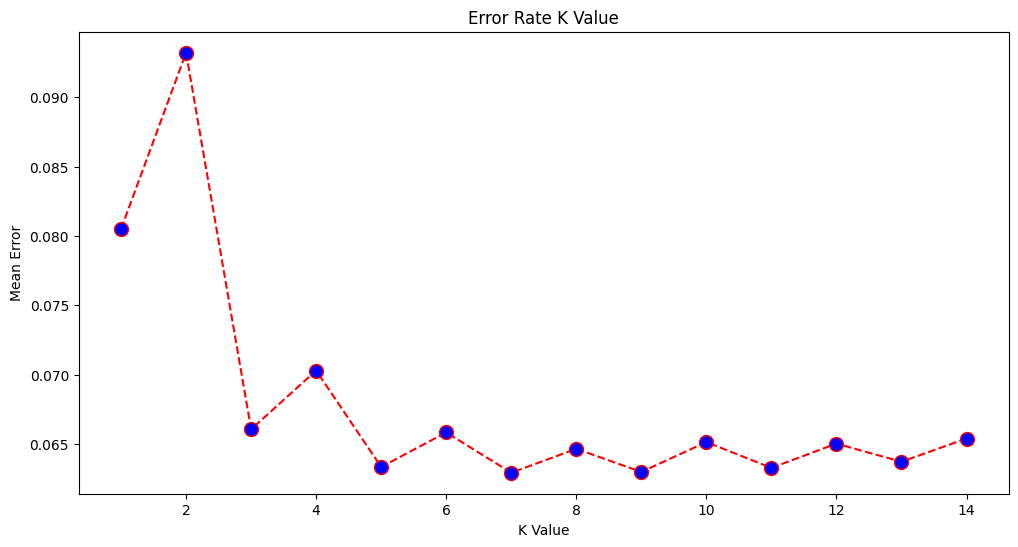

In [16]:


plt.figure(figsize=(12, 6))
plt.plot(range(1, 15), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')



In [17]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(x_train_os, y_train_os)
y_pred = knn.predict(x_test)
acuracia = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

In [18]:
print(f"Acurácia: {acuracia:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Acurácia: 0.9363

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.61      0.64     25202
           1       0.96      0.97      0.97    243222

    accuracy                           0.94    268424
   macro avg       0.82      0.79      0.80    268424
weighted avg       0.93      0.94      0.93    268424



Exportando o modelo para criar o serviço

In [19]:
import pickle

with open('model.pkl', 'wb') as arquivo:
    pickle.dump(resultados["KNN"]["modelo"], arquivo)